In [84]:
import time
from itertools import product

import pandas as pd
from pandas.tseries.frequencies import to_offset
import numpy as np
import vectorbtpro as vbt
import warnings
warnings.filterwarnings("ignore")

In [85]:
# This is the number of days we'll look back to 
# calculate the rolling z-score.
window = 22

# This is the number of standard deviations the 
# z-score needs to be above or below to trigger
# a trading signal.
thresh = 2

# Set the end date to today.
end = pd.Timestamp.today().strftime("%Y-%m-%d")

In [86]:
# Paramaterize the refiner symbol to easily swap
# them out.
refiner_symbol = "VLO"

In [87]:
# Use the VectorBT data download functionality to
# grab price history data.
data = vbt.YFData.pull(
    [
        "CL=F", 
        "RB=F", 
        "HO=F", 
        refiner_symbol
    ], 
    start="2020", 
    end=end,
    missing_index="drop"
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [88]:
# The data object requires us to extract the data.
cl = data.get("Close")["CL=F"]
rb = data.get("Close")["RB=F"]
ho = data.get("Close")["HO=F"]
refiner = data.get("Close")[refiner_symbol]

In [89]:
# Construct the crack spread which is defined as
# long one heating oil contract, long two gasoline
# contracts, and short three crude oil contracts.
crack_spread = ho + 2 * rb - 3 * cl

<Axes: xlabel='Date'>

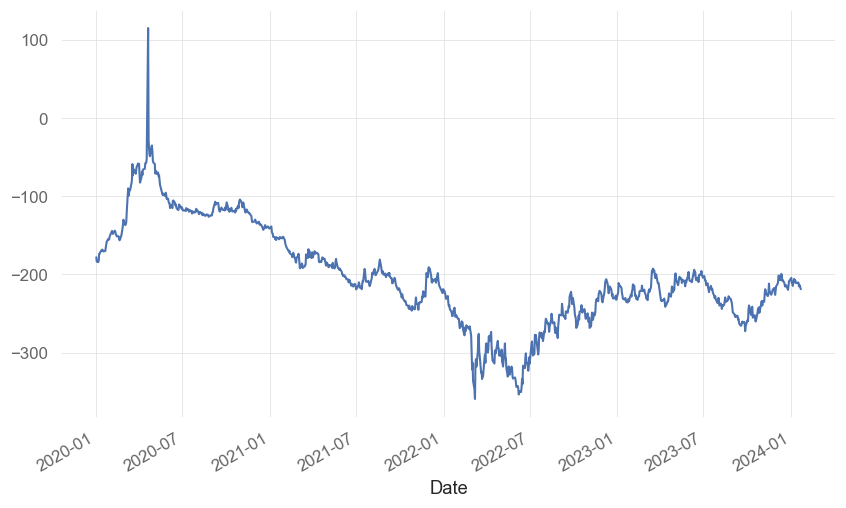

In [90]:
# Plot it.
crack_spread.plot()

In [91]:
# Now use the percentile rank to normalize the spread so we can
# compare it to the refiner stock
crack_spread_rank = crack_spread.rolling(window).rank(pct=True)

<Axes: xlabel='Date'>

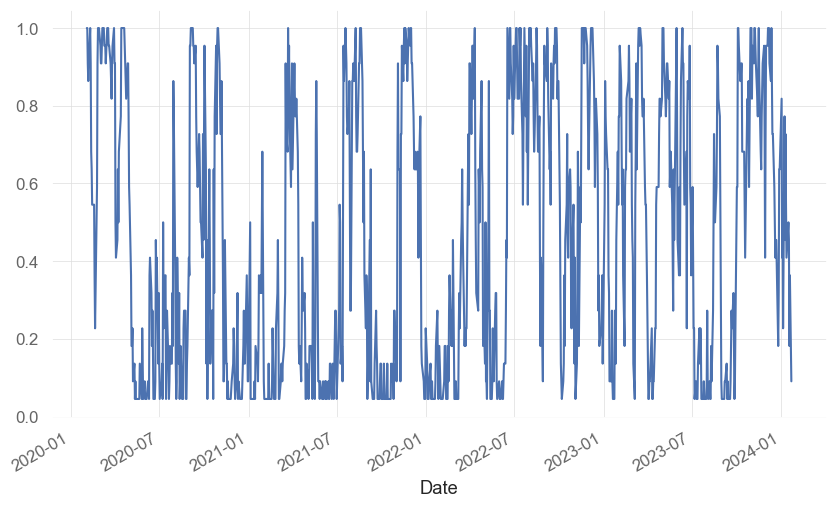

In [92]:
# Plot it.
crack_spread_rank.plot()

In [93]:
# Compute the percentile rank for the refiner's price
refiner_rank = refiner.rolling(window).rank(pct=True)

<Axes: xlabel='Date'>

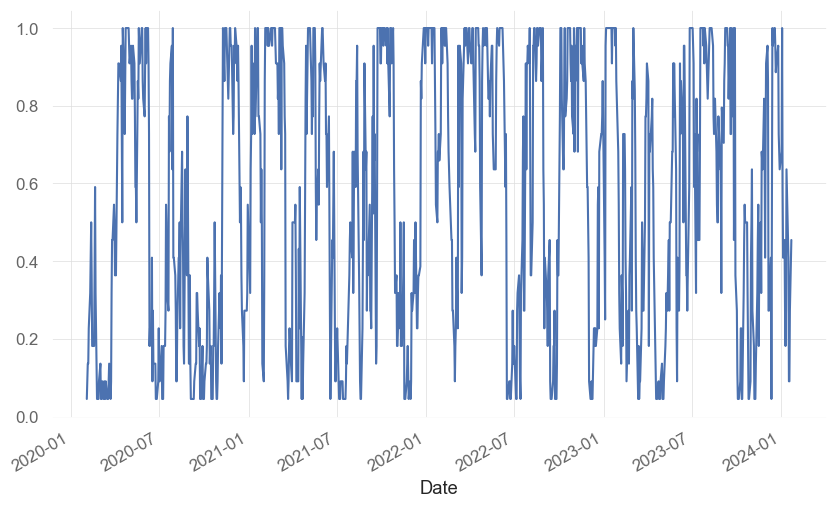

In [94]:
# Plot it.
refiner_rank.plot()

In [95]:
# Now compare the difference between the price performance by
# subtracting the rank
rank_spread = refiner_rank - crack_spread_rank

<Axes: xlabel='Date'>

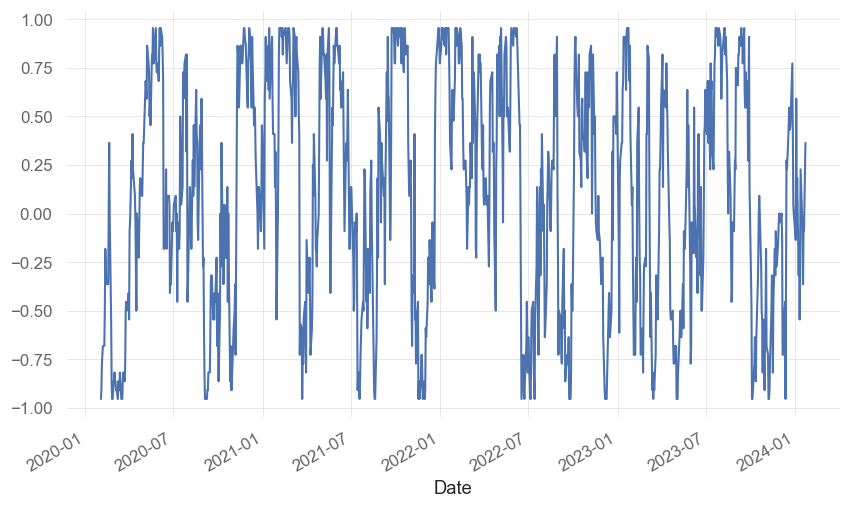

In [96]:
# Plot it.
rank_spread.plot()

In [97]:
# Normalize the difference by taking the z-score which forms our
# trading signal.
roll = rank_spread.rolling(window)
zscore = ((rank_spread - roll.mean()) / roll.std())

<Axes: xlabel='Date'>

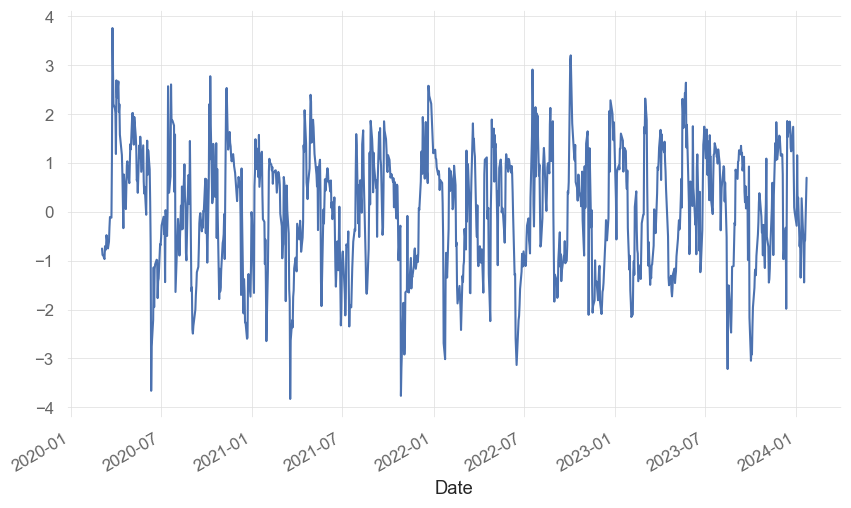

In [98]:
# Plot it.
zscore.plot()

In [99]:
# Find all occurences where the z-score crosses below the lower
# threshold and get long. Then set an exit when the z-score crosses
# above -1. Filter out all entry signals if the position has already 
# been entered, and exit signals if the position has already been exited.
long_entries = zscore.vbt.crossed_below(-thresh)  # long entries
long_exits = zscore.vbt.crossed_above(thresh)
clean_long_entries, clean_long_exits = long_entries.vbt.signals.clean(long_exits)

In [100]:
# Visualize long entries and exists
fig = zscore.vbt.plot()
clean_long_entries.vbt.signals.plot_as_entries(zscore, fig=fig)
clean_long_exits.vbt.signals.plot_as_exits(zscore, fig=fig)
fig.add_hline(y=thresh, line_color="orangered", line_dash="dot")
fig.add_hline(y=0, line_color="yellow", line_dash="dot")
fig.add_hline(y=-thresh, line_color="limegreen", line_dash="dot")
fig.show()

In [101]:
# Find all occurences where the z-score crosses above the upper
# threshold and get short. Then set an exit when the z-score crosses
# below 1. Filter out all entry signals if the position has already 
# been entered, and exit signals if the position has already been exited.
short_entries = zscore.vbt.crossed_above(thresh)  # short entries
short_exits = zscore.vbt.crossed_below(-thresh)
clean_short_entries, clean_short_exits = short_entries.vbt.signals.clean(short_exits)

In [102]:
# Visualize short entries and exists
fig = zscore.vbt.plot()
clean_short_entries.vbt.signals.plot_as_exits(zscore, fig=fig)
clean_short_exits.vbt.signals.plot_as_entries(zscore, fig=fig)
fig.add_hline(y=thresh, line_color="orangered", line_dash="dot")
fig.add_hline(y=0, line_color="yellow", line_dash="dot")
fig.add_hline(y=-thresh, line_color="limegreen", line_dash="dot")
fig.show()

In [103]:
# Run a backtest based on the closing price of the refiner using the z-score of the
# spread between the percentile rank of refiner and the crack spread as the
# entry and exit signals. Trade 10 shares and start with 25K.
pf = vbt.Portfolio.from_signals(
    close=refiner,
    entries=clean_long_entries,
    exits=clean_long_exits,
    # short_entries=clean_short_entries,  # if you want to go short
    # short_exits=clean_short_exits,  # if you want to go short
    size=1.0,  # 10% invested
    size_type="percent",
    init_cash=25_000,
    freq="1D"
)

In [104]:
# Print out the summary stats from the initial backtest.
pf.stats()

Start                         2020-01-02 00:00:00-05:00
End                           2024-01-22 00:00:00-05:00
Period                               1020 days 00:00:00
Start Value                                     25000.0
Min Value                                  17950.225132
Max Value                                  43316.882613
End Value                                  33638.008462
Total Return [%]                              34.552034
Benchmark Return [%]                          63.643937
Total Time Exposure [%]                       52.254902
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              34.146339
Max Drawdown Duration                 408 days 00:00:00
Total Orders                                         15
Total Fees Paid                                     0.0
Total Trades                                          8
Win Rate [%]                                  42.857143
Best Trade [%]                                39

In [105]:
# Plot charts of orders along, trades, and cumulative returns.
pf.plot(settings=dict(bm_returns=False)).show()

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-06-12   2020-06-12
End Period                 2024-01-22   2024-01-22
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       59.0%

Cumulative Return          149.65%      34.55%
CAGR﹪                     19.1%        5.83%

Sharpe                     0.95         0.51
Prob. Sharpe Ratio         93.99%       78.7%
Smart Sharpe               0.93         0.49
Sortino                    1.51         0.73
Smart Sortino              1.47         0.71
Sortino/√2                 1.06         0.52
Smart Sortino/√2           1.04         0.5
Omega                      1.09         1.09

Max Drawdown               -44.33%      -34.15%
Longest DD Days            238          594
Volatility (ann.)          53.08%       37.51%
R^2                        0.5          0.5
Information Ratio          -0.04        -0.04
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-06-17,2020-10-01,2021-03-05,262,-34.146339,-33.666586
2,2022-06-08,2022-12-09,2024-01-22,594,-32.394624,-29.658535
3,2021-03-12,2021-08-20,2022-03-22,375,-30.933959,-29.234326
4,2022-04-19,2022-04-25,2022-04-27,9,-8.581784,-6.615306
5,2022-05-09,2022-05-09,2022-05-26,18,-8.306224,-6.355467


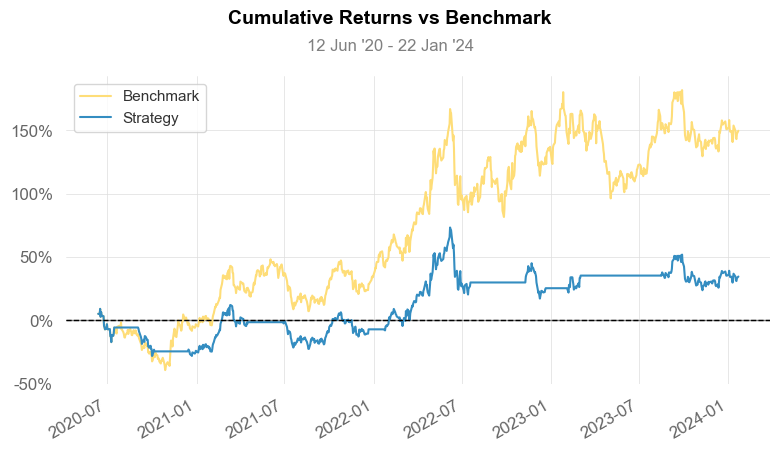

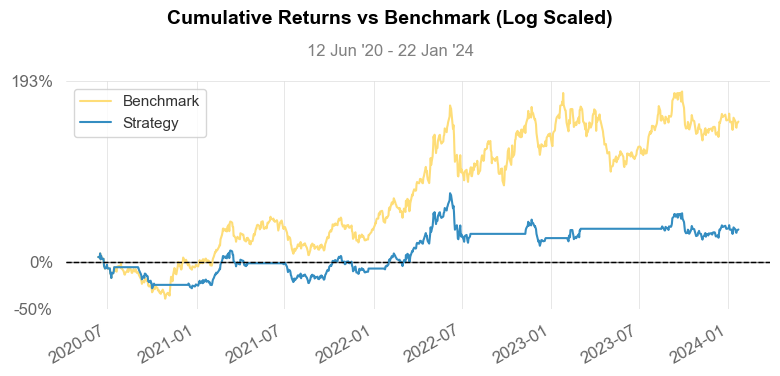

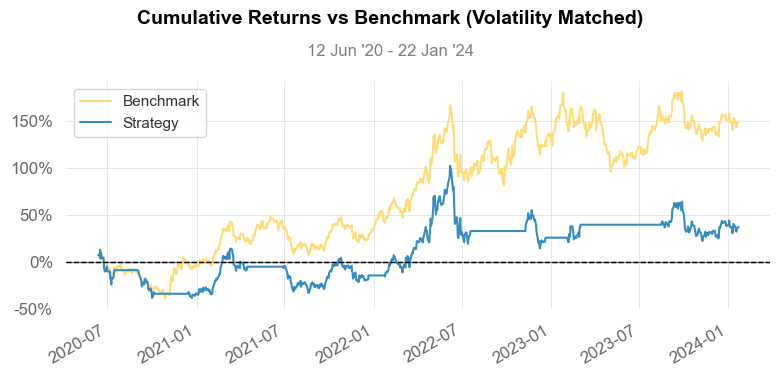

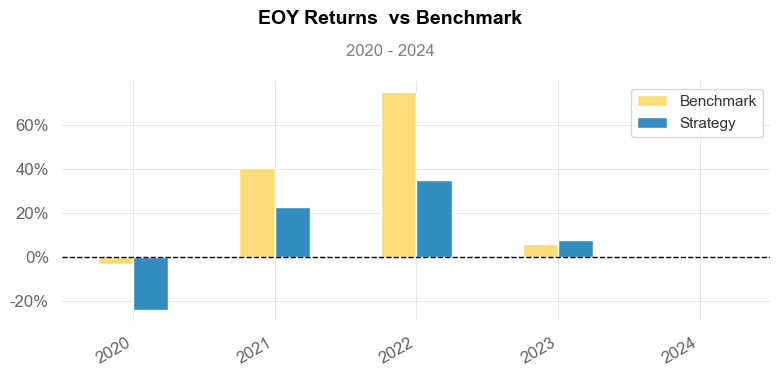

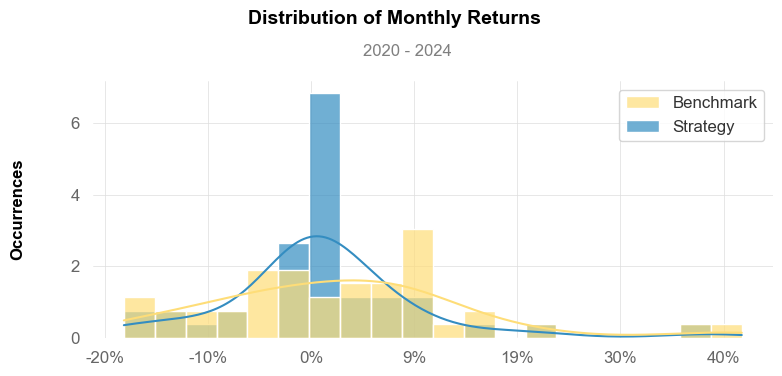

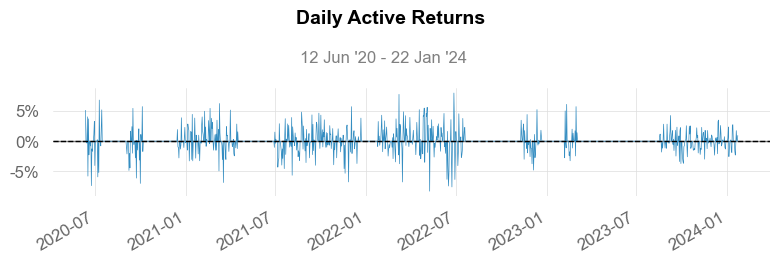

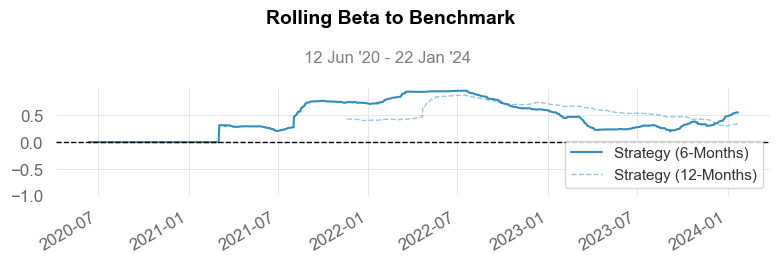

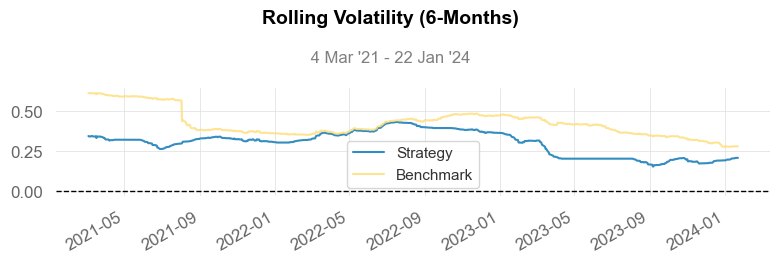

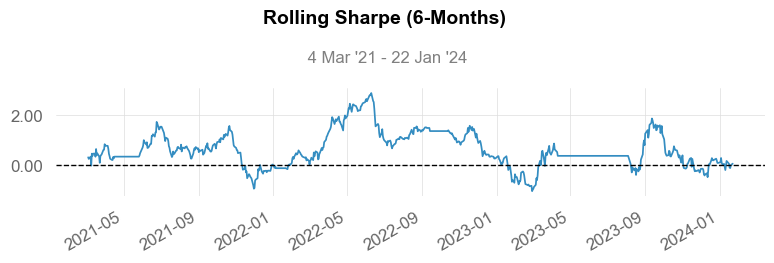

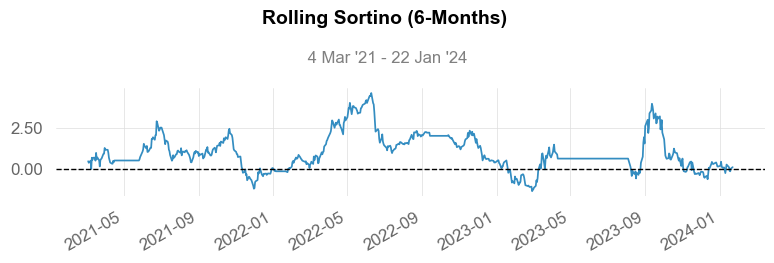

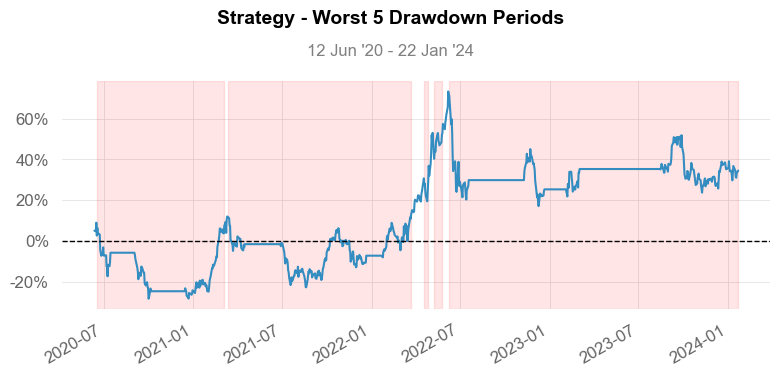

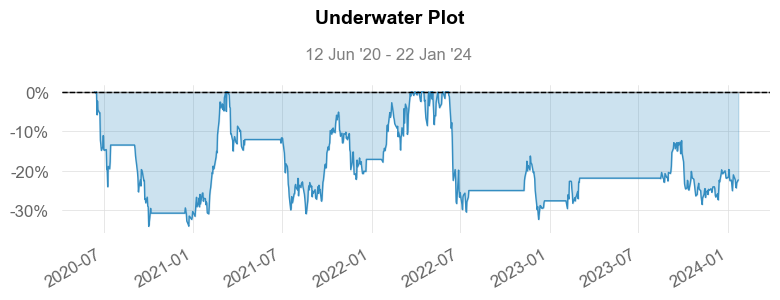

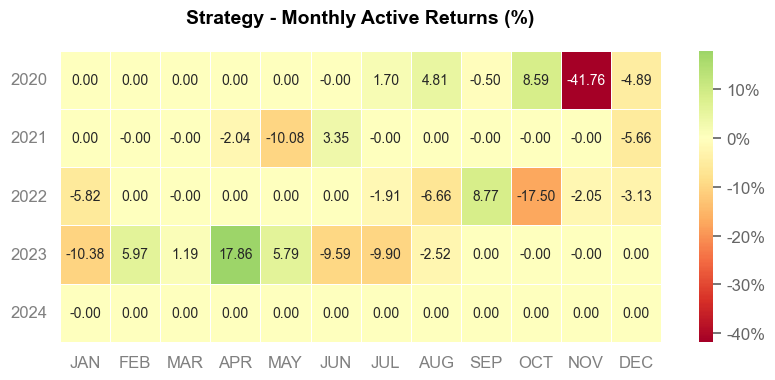

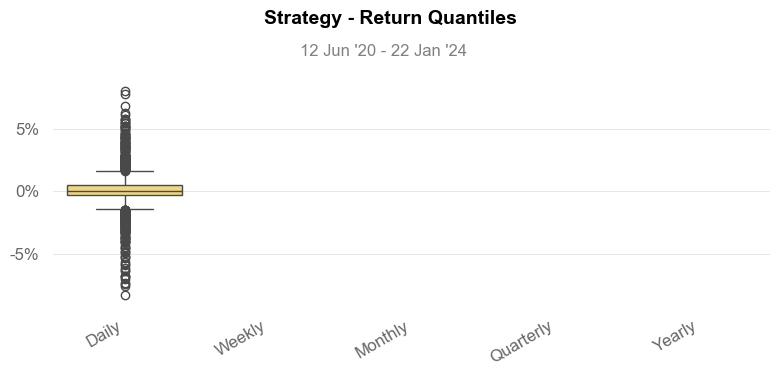

In [106]:
# Generate a Quantstats report.
pf.qs.full_report()

# Time to optimize

In [107]:
# Generate a function that accepts the parameters we want to optimize.
# In our case they are the entry and exit thresholds. The rest of the
# code is the same as before.
def test_strat(entry_th=2, exit_th=0):
    
    # Generate long entries
    long_entries = zscore.vbt.crossed_below(-entry_th)  # long entries
    long_exits = zscore.vbt.crossed_above(exit_th)
    clean_long_entries, clean_long_exits = long_entries.vbt.signals.clean(long_exits)
    
    # Generate short entries
    short_entries = zscore.vbt.crossed_above(entry_th)  # short entries
    short_exits = zscore.vbt.crossed_below(-exit_th)
    clean_short_entries, clean_short_exits = short_entries.vbt.signals.clean(short_exits)
    
    # Run the backtest
    pf = vbt.Portfolio.from_signals(
        close=refiner,
        entries=clean_long_entries,
        exits=clean_long_exits,
        # short_entries=clean_short_entries,  # if you want to go short
        # short_exits=clean_short_exits,  # if you want to go short
        size=1.0,  # Fully invested
        size_type="percent",
        init_cash=25_000,
        freq="1D"
    )

    return pf.stats([
        "total_return",
        "total_trades",
        "win_rate",
        "expectancy"
    ])
    


In [108]:
# Run the function with the defaults to return the total return,
# total trade count, win rate, and expectancy.
test_strat()

Total Return [%]    -40.90049
Total Trades               16
Win Rate [%]             50.0
Expectancy         -639.07016
dtype: object

In [109]:
# Generate a range of entry and exit threholds between 0.01 and 3.4.
entry_th = [i / 10 for i in range(1, 35)]
exit_th = [i / 10 for i in range(1, 35)]

In [110]:
# Combine the thresholds together into a list of tuples that contain
# every combination of entry and exit thresholds. There are 1156
# different combinations we'll backtest.
th_combs = list(product(entry_th, exit_th))
len(th_combs)

1156

In [111]:
# Run all the different combinations of strategies to find the optimal
# combination of entry and exit thresholds. This takes about 30 seconds.
start_time = time.time()
comb_stats = [
    test_strat(entry_th=entry_th, exit_th=exit_th)
    for entry_th, exit_th in th_combs
]
print(f"Run took ~{int(time.time() - start_time)} seconds")

Run took ~127 seconds


In [112]:
# Convert the backtest combinations from a list to a DataFrame with 
# metrics arranged as columns:
comb_stats_df = pd.DataFrame(comb_stats)
comb_stats_df

,Total Return [%],Total Trades,Win Rate [%],Expectancy
0,28.062892,65,69.230769,107.934201
1,27.674221,62,70.967742,111.589602
2,36.103440,60,70.000000,150.430999
3,37.220611,59,71.186441,157.714452
4,39.030615,57,71.929825,171.186907
...,...,...,...,...
1151,108.346372,1,100.000000,27086.593091
1152,108.346372,1,100.000000,27086.593091
1153,118.122751,1,100.000000,29530.687717
1154,149.646654,1,NaN,NaN


In [113]:
# Build a MultiIndex DataFrame with two levels, entry_th and exit_th, 
# and make it the index of comb_stats_df. This aligns each run with 
# that run's statistics.
comb_stats_df.index = pd.MultiIndex.from_tuples(
    th_combs, 
    names=['entry_th', 'exit_th']
)
comb_stats_df

Total Return [%]  Total Trades  Win Rate [%]    Expectancy
entry_th exit_th                                                            
0.1      0.1             28.062892            65     69.230769    107.934201
         0.2             27.674221            62     70.967742    111.589602
         0.3             36.103440            60     70.000000    150.430999
         0.4             37.220611            59     71.186441    157.714452
         0.5             39.030615            57     71.929825    171.186907
...                            ...           ...           ...           ...
3.4      3.0            108.346372             1    100.000000  27086.593091
         3.1            108.346372             1    100.000000  27086.593091
         3.2            118.122751             1    100.000000  29530.687717
         3.3            149.646654             1           NaN           NaN
         3.4            149.646654             1           NaN           NaN

[1156 rows x 4 columns]

In [114]:
# Plot a heatmap to see where our parameter combinations 
# perform well.
comb_stats_df['Total Return [%]'].vbt.heatmap().show()

In [115]:
# Find the paramter combination that maximizes the in sample
# return
total_returns = comb_stats_df['Total Return [%]']
max_total_return = comb_stats_df['Total Return [%]'].max()
comb_stats_df[total_returns == max_total_return]

,,Total Return [%],Total Trades,Win Rate [%],Expectancy
entry_th,exit_th,,,,
0.2,2.6,283.532869,6,60.0,10615.448596


In [116]:
# And run the strategy with these results.
test_strat(0.8, 0.1)

Total Return [%]    -36.184552
Total Trades                45
Win Rate [%]         71.111111
Expectancy         -201.025289
dtype: object